# Molecular dynamics: stochastic continuous time models

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.stats
from scipy.integrate import solve_ivp
import seaborn as sns
plt.warnings.filterwarnings('ignore', category=FutureWarning)
                            #"The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.")
sns.set_context('talk')

from functools import partial

# Gene expression model

Much of this session follows [Justin Bois](http://be150.caltech.edu/2017/handouts/gillespie_simulation.html)'s handouts.

For simple protein production, we have the following reactions:

\begin{align}
\text{DNA} \rightarrow \text{mRNA} \rightarrow \text{protein}
\end{align}

![expression](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Genetic_code.svg/320px-Genetic_code.svg.png)

A more quantitative description is:

- DNA moelcules are constat in a cell
- mRNA molecules are produced with rate $\beta_m$ from DNA molecules
- mRNA molecules break (ie die) at a rate $\gamma_m$
- Protein molecules are produced at a rate $\beta_p$ from mRNA molecules
- Protein molecules break (ie die), at a rate $\gamma_p$

![dynamics](../resources/molecular-dynamics-chart.png)

## Master equation

$f(m, p, t)$ is the probability of $m$ mRNA molecules and $p$ protein molecules at time $t$.

The differential equation which describes the change in $f(m, p, t)$ over time is often called a **master equation**:

$$
\frac{d f(m,p,t)}{dt} = \\
\beta_m \cdot f(m-1,p,t) + 
(m+1) \gamma_m \cdot f(m+1,p,t) - 
\beta_m \cdot f(m,p,t) - 
m \gamma_m \cdot f(m,p,t) + \\
m \beta_p \cdot f(m,p-1,t) + 
(p+1) \gamma_p \cdot f(m,p+1,t) - 
\beta_p m \cdot f(m,p,t) - 
p \gamma_p \cdot f(m,p,t).
$$

where the second line describes mRNA dynamics and the third line described protein dynamics.
Note that $m$ and $p$ are positive integers and $t$ is a non-negative real number; also, $f(m,p,t)$ is a probability so $0 \le f(m,p,t) \le 1$ and $\sum_{m \ge 0}{\sum_{p \ge 0}{f(m,p,t)}} = 1$.

# Deterministic method
The _deterministic_ equations, which describe the dynamics over a very large number of independent of replicate dynamics (ie cells), is derived by taking the expectation of $m$ and $p$, which yields

$$
\frac{dm}{dt} = \beta_m - \gamma_m m, \\
\frac{dp}{dt} = \beta_p m - \gamma_p p.
$$

Note that these dynamics are linear in $m$ and $p$, and are therefore much simpler than the predator-prey dynamics of the [Lotka-Volterra equations](lotka-volterra.ipynb).

## Equilibrium and stability
The equilibrium can be calculated by equating both derivatives to zero:

$$
m^* = \frac{\beta_m}{\gamma_m}, \\
p^* = \frac{\beta_p}{\gamma_p} m^* = \frac{\beta_m \beta_p}{\gamma_m \gamma_p}.
$$

Note: $^*$ is a common symbol for equilibrium values.

The Jacobian of the ODE system is

$$
J = \pmatrix{
\frac{d^2m}{dtdm} & \frac{d^2m}{dtdp} \\
\frac{d^2p}{dtdm} & \frac{d^2p}{dtdp} \\
} = 
\pmatrix{
-\gamma_m & 0 \\
\beta_p & -\gamma_p
}.
$$

The eigenvalues of $J$ are the main diagonal values, $-\gamma_m$ and $-\gamma_p$ (the matrix is already in Jordan form).
Both eigenvalues $-\gamma_m$ and $-\gamma_p$ are real and negative, so the equilibrium is **locally stable** -- with small enough perturbations, the system returns to the equilibrium $(m^*, p^*)$.

In fact we could also show that it is globally stable, i.e. the system reaches $(m^*, p^*)$ regardless of the initial conditions, as long as $\beta_m, \beta_p > 0$.

Let's verify these statements by using numerical integration.

Before we do, let's reduce the number of parameters by changing time from whatever unit is was before (seconds? miliseconds? we should consult with the literature or a molecular biologist) to be in units of $1/\gamma_m$, so we have

$$
\frac{dm}{dt} = \beta_m - m, \\
\frac{dp}{dt} = \beta_p m - \gamma_p p,
$$

and the rates $\beta_m$, $\beta_p$, and $\gamma_p$ are in time units of $1/\gamma_m$, or "the average time for breaking mRNA molecules".

We write the gradient function, an integration function using [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), and a plot function.

In [6]:
def gradient(t, mp, βm, βp, γp):
    m, p = mp
    return (βm - m, 
            βp * m - γp * p)

def integrate_deterministic(βm, βp, γp, mp0=(0, 0), tmax=50, tsteps=1000):
    gradient_ = partial(gradient, βm=βm, βp=βp, γp=γp)
    t = np.linspace(0, tmax, tsteps)
    sol = solve_ivp(gradient_, t_span=(0, t.max()), y0=mp0, t_eval=t)
    m, p = sol.y
    return t, m, p

def plot_mp(t, m, p, label='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(t, m, lw=3, label='m ' + label)
    ax.plot(t, p, lw=3, label='p ' + label)
    ax.set_xlabel('Time')
    ax.set_ylabel('Count')
    ax.legend()
    return ax

Now plot the numerical solution for specific parameters and compare to the analytic solution for the equilibrium $m^*=\beta_m$, $p^*=\beta_m \beta_p / \gamma_p$.

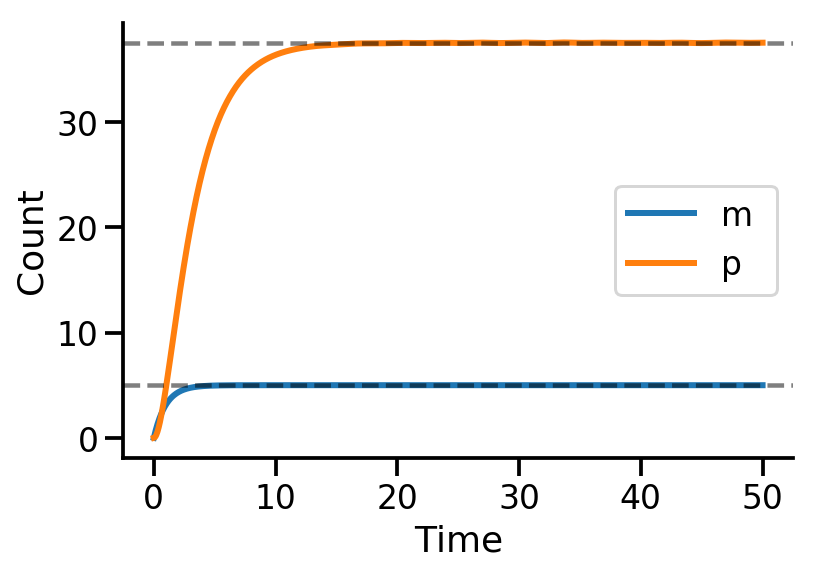

In [7]:
hline_kws = dict(ls='--', alpha=0.5, color='k')

βm, βp, γp = 5, 3, 0.4
T, M, P = integrate_deterministic(βm, βp, γp)
ax = plot_mp(T, M, P)
ax.axhline(βm, **hline_kws)
ax.axhline(βm * βp / γp, **hline_kws)
sns.despine()

# Stochastic method: Gillespie algorithm

Note that the equilibrium of the mRNA is $\beta_m=3$, so if we look at specific cells (replications of the dynamics) we might expect to see cells with 4-6 molecules and cells with 0 molecules.
But, cells with 0 mRNA molecules will not produce protein!
Also, maybe we are interested in understanding the variance in this system -- between cells and within cells.

To implement a stochastic integration method, we first write the master equation as a list of reactions and their corresponding rates:

\begin{align}
\begin{array}{ll}
\text{reaction, }r_i & \text{rate, } a_i \\
m \rightarrow m+1,\;\;\;\; & \beta_m \\
m \rightarrow m-1, \;\;\;\; & m\\
p \rightarrow p+1, \;\;\;\; & \beta_p m \\
p \rightarrow p-1, \;\;\;\; & \gamma_p p.
\end{array}
\end{align}

The **Gillespie algorithm** is a method for sampling from the probability distribution $f(m,p,t)$.
It was proven by Dobbs and later implemented by Gillespie ([1976](https://www.sciencedirect.com/science/article/pii/0021999176900413), [1977](https://pubs.acs.org/doi/abs/10.1021/j100540a008?journalCode=jpchax)), see the papers for the technical details (or come see me).

The idea is that reactions are rare and discrete, and therefore represent separate events which can be modeled by a *Poisson process* with exponentially distributed waiting times.

Let's plot exponential random variables to recall what their distribution looks like.
NumPy's exponential random number generator accepts the mean value, or the 1/rate:

0.9947741305359735 1
2.002522274938579 2
10.039678176924893 10


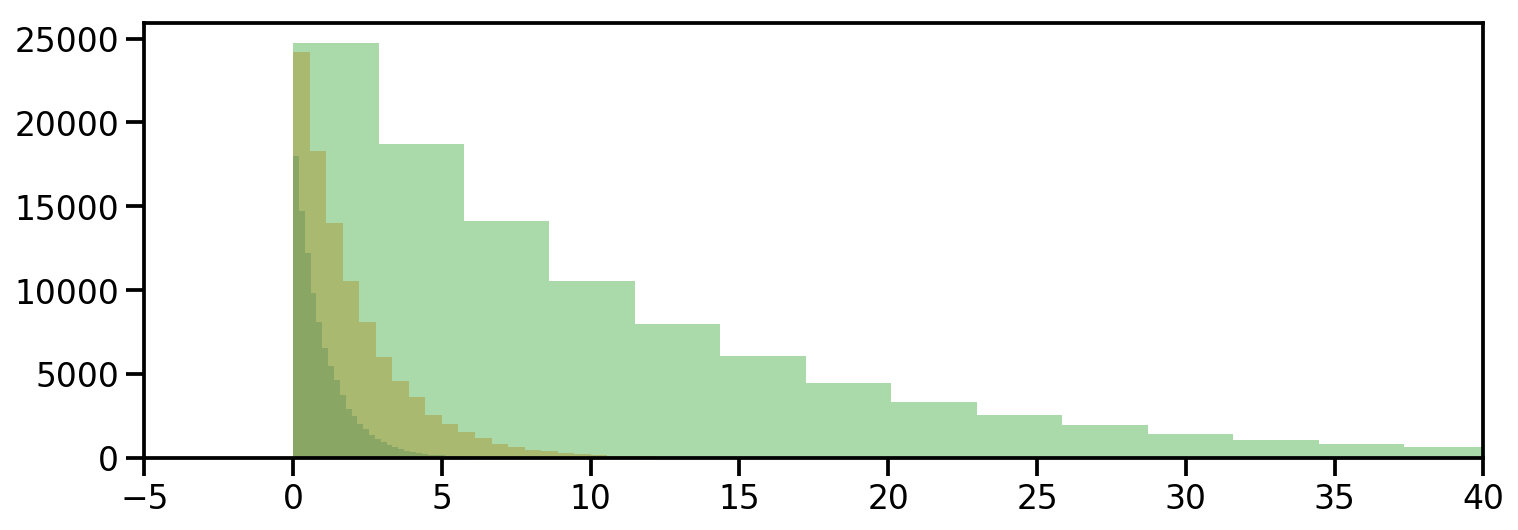

In [15]:
n = 100000
x1 = np.random.exponential(1, size=n)
x2 = np.random.exponential(2, size=n)
x10 = np.random.exponential(10, size=n)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
kwargs = dict(kde=False)
sns.distplot(x1, **kwargs, label='Exp(1)')
sns.distplot(x2, **kwargs, label='Exp(2)')
sns.distplot(x10, **kwargs, label='Exp(10)')
ax.set_xlim(-5, 40)

print(x1.mean(), 1)
print(x2.mean(), 2)
print(x10.mean(), 10)

Recall from probability theory that the minimum of $n$ exponentially distributed waiting times is exponentioally distributed; the rate of the minimum is the sum of the rates. 
So, if the waiting times for the different reactions are exponentially distributed with rates $a_i$, then the waiting time for the next reaction (whatever it is) is also exponentially distributed with rate $\sum_i{a_i}$. 

0.6238948027453309 0.625


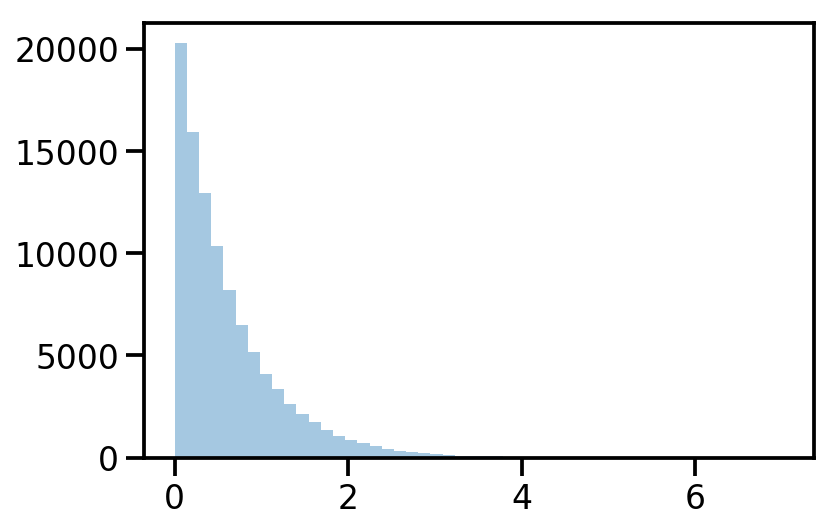

In [16]:
x_min = np.minimum(x1, x2)
x_min = np.minimum(x_min, x10)

sns.distplot(x_min, **kwargs)
ax.set_xlim(-5, 40)

print(x_min.mean(), 1/(1+1/2+1/10))

Given that some reaction occured, the probability that it was reaction $r_i$ is $\frac{a_i}{\sum_j{a_j}}$.

So the algorithm works like this, starting with an initial state $s_0 = (m_0, p_0)$:
1. Set time $t=0$.
1. Calculate the reaction rates $a_i$ using current state $s_t$.
1. Calculate the sum of rates, $\sum_i{a_i}$.
1. Draw the waiting time for the next reaction $\Delta t$ from exponential distribution $Exp(\sum_i{a_i})$.
1. Draw the type of the reaction from multinomial distribution $Multinomial(1, a_i/\sum_j{a_j})$.
1. Find the state change $\Delta m, \Delta p$ due to reaction $r_i$
1. Update the state $s_{t+\Delta t} = (m_t + \Delta m, p_t + \Delta p)$.
1. Update the time $t \to t + \Delta t$.
1. If not finished (e.g. $t<T$), go to (2).

## Implementation

First, a function that calculates the reaction rates.

[Numba](http://numba.pydata.org) is used here to accelerate the function by passing it through a JIT compiler.

In [17]:
@numba.jit # 2-fold faster
def get_rates(m, p, βm, βp, γp):
    return np.array([
        βm,     # mRNA production
        m,      # mRNA degradation
        βp * m, # protein production
        γp * p  # protein degradation
    ])

Draw the time for the next reaction:

In [18]:
@numba.jit # 2-fold faster
def draw_time(rates):
    total_rate = rates.sum()
    return np.random.exponential(1/total_rate)

Draw the reaction type:

In [19]:
# @numba.jit # jit causes errors with multinomial
def draw_reaction(rates):
    rates /= rates.sum()
    return np.random.multinomial(1, rates).argmax()

Updates matrix, `updates[i,j]` is the change in reactant `j` due to reaction `i`; `j=0` for mRNA and `j=1` for protein.

In [20]:
updates = np.array([
    [1, 0],  # mRNA production
    [-1, 0], # mRNA degradation
    [0, 1],  # protein production
    [0, -1]  # protein degradation
])

One step of the simulation goes through a single update.

In [21]:
def gillespie_step(m, p, βm, βp, γp):
    rates = get_rates(m, p, βm, βp, γp)
    Δt = draw_time(rates)
    ri = draw_reaction(rates)
    Δm, Δp = updates[ri]
    return Δt, Δm, Δp

In [22]:
t, m, p = 0, 0, 0

In [23]:
Δt, Δm, Δp = gillespie_step(m, p, 10, 10, 0.4)
t, m, p = t+Δt, m+Δm, p+Δp
print(t, m, p)

0.008256859961404987 1 0


Now a full Gillespie stochastic simulation algorithm. We stop when $t \ge t_{max}$.

`output` keeps track of the simulation results.
The first axis is the record type - time, mRNA, and protein.
The second axis is time.

Note that time is not discrete and time steps are not constant, hence we keep for each time step (axis=1) the time (first array in axis=0).

In [24]:
def gillespie_ssa(βm, βp, γ, t0=0, m0=0, p0=0, t_steps=1000, tmax=10):
    times = np.linspace(t0, tmax, t_steps) # recording times: time points in which to record the state
    states = np.empty((updates.shape[1], t_steps), dtype=int) # recorded states
    
    # init
    t = t0
    m, p = m0, p0
    Δm, Δp = 0, 0
    # loop over recording times
    for i, next_t in enumerate(times):
        # simulate until next recording time
        while t < next_t:
            Δt, Δm, Δp = gillespie_step(m, p, βm, βp, γ)
            t, m, p = t+Δt, m+Δm, p+Δp
        # record the previous state for the time point we just passed
        states[:, i] = m - Δm, p - Δp
    # return array equivalent to [[times, mRNA, protein] for t in times]
    return np.concatenate((times.reshape(1, -1), states), axis=0)

## Simulation

Run a single simulation and plot it.

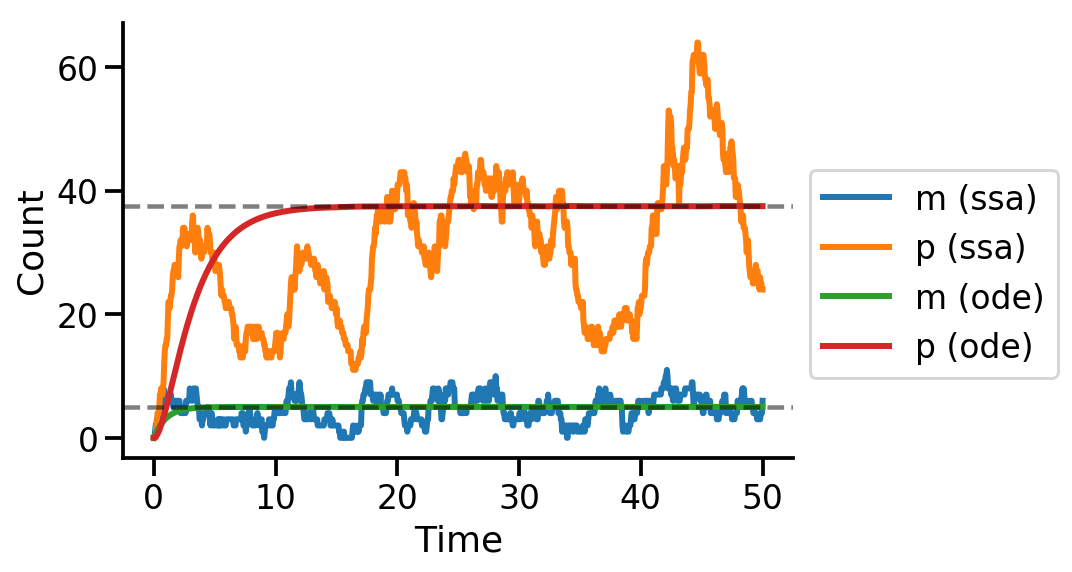

In [28]:
t, m, p = gillespie_ssa(βm, βp, γp, tmax=50)

ax = plot_mp(t, m, p, label='(ssa)')
plot_mp(T, M, P, label='(ode)', ax=ax)
ax.axhline(βm, **hline_kws)
ax.axhline(βm*βp/γp, **hline_kws)
ax.legend(bbox_to_anchor=(1, 0.7))
sns.despine()

There is quite a lot of noise here!

## Compare stochastic and deterministic
Run the Gillespie algorithm 100 times and compare it to the deterministic dynamics.

In [30]:
%%time
tmp = np.array([gillespie_ssa(βm, βp, γp, tmax=50) for _ in range(100)])
T, M, P = integrate_deterministic(βm, βp, γp, tmax=50)

CPU times: user 4.59 s, sys: 34.9 ms, total: 4.62 s
Wall time: 4.87 s


We plot all the simulated trajectories, but with transparency so we can see them all, and their mean value.

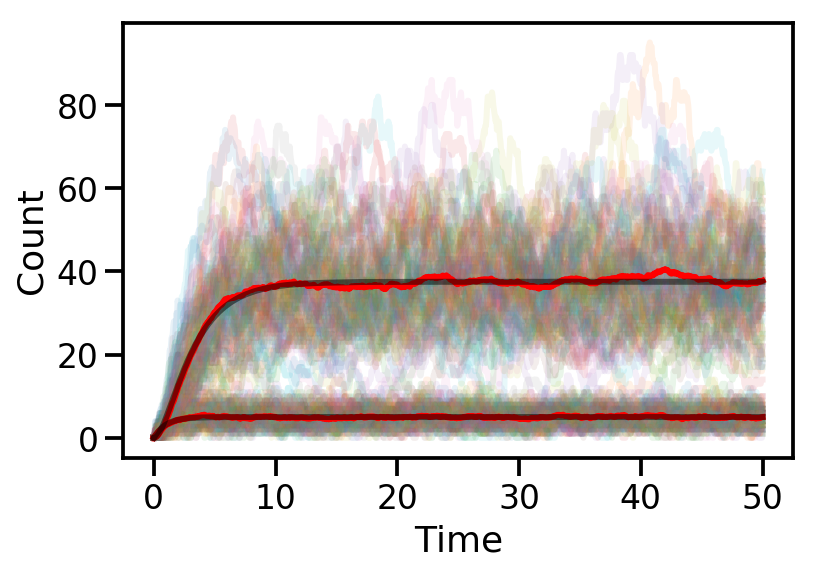

In [33]:
fig, ax = plt.subplots()

# axes of tmp are (replicates, states, times)
t = tmp[0, 0, :] # time is the same in all replicates, see first line of gillespie_ssa
m = tmp[:, 1, :]
p = tmp[:, 2, :]

plot_mp(t, m.T, p.T, ax=ax) # plot independent trajectories
for line in ax.get_lines(): # transparency
    line.set_alpha(0.1) 
plot_mp(t, m.mean(axis=0), p.mean(axis=0), ax=ax, label='(mean)') # plot mean of all gillespie trajectories
for line in ax.get_lines()[-2:]:
    line.set_color('r')
plot_mp(T, M, P, ax=ax, label='(ode)') # plot ode solution
for line in ax.get_lines()[-2:]:
    line.set_color('k')
    line.set_alpha(0.5)
    
ax.legend().set_visible(False)

We can see that indeed the mean of the stochastic dynamics is very close to the ODE solution, even with just 100 replicates (cells).

It is also interesting to remember that mRNA and protein covary togather: changes in mRNA cause changes in protein production.

We plot the joint and marginal distributions of mRNA and protein.
We add the equilibrium expectation on the marginals as a dashed line and on the joint as a marker.

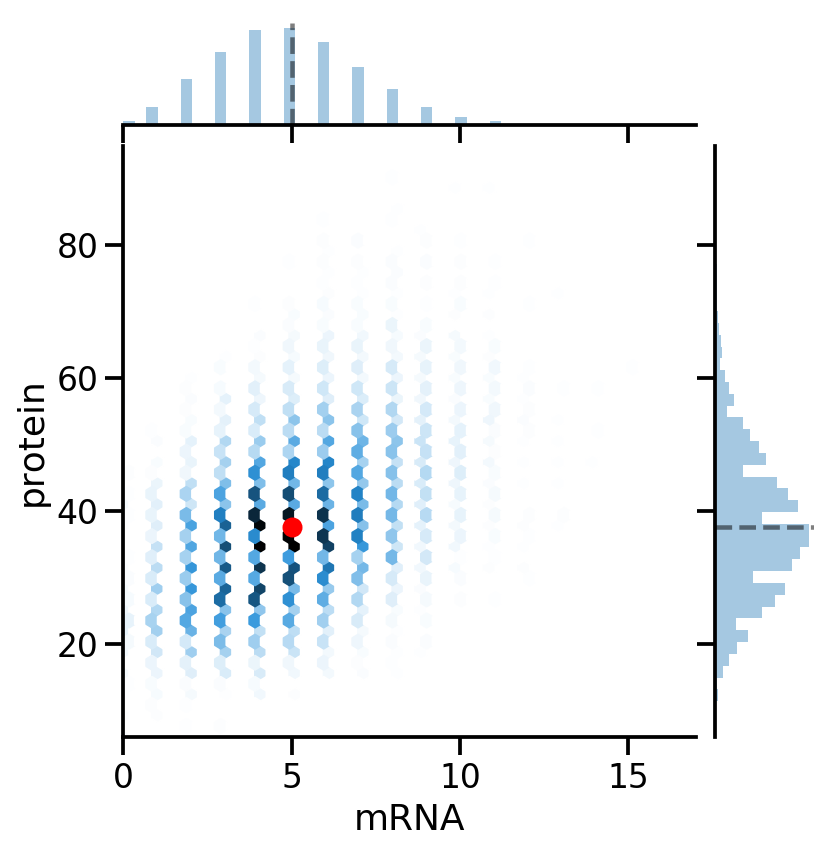

In [34]:
n = t.shape[0]//2 # take just the last half of the dynamics, after they stabilized

g = sns.jointplot(m[:,n:].ravel(), p[:,n:].ravel(), kind='hex')
g.ax_marg_x.axvline(βm, **hline_kws)
g.ax_marg_y.axhline(βm * βp / γp, **hline_kws)
g.ax_joint.plot(βm, βm * βp / γp, 'or')
g.set_axis_labels(xlabel='mRNA', ylabel='protein');

We can see that the equilibrium is a good expectation, but that there is much variance: there are many cases with 2 or less mRNA molecules, although the equilibrium is at 5.

Also, some cells sometimes won't have any mRNA:

In [35]:
m_ = m[:, n//2:].ravel()
print('Fraction of zero mRNA: {:.4%}'.format((m_ == 0).mean()))

Fraction of zero mRNA: 0.7893%


# References
- Gillespie algorithm on [Wikipedia](https://en.wikipedia.org/wiki/Gillespie_algorithm)
- [StochPy](http://stochpy.sourceforge.net/) - Python package for stochastic simulation
- [SEIR model sotchastic model example](https://github.com/naddleman/SEIR-stochastic)
- [SimPy](https://simpy.readthedocs.io/) - Generator based stochastic simulator in Python
- [Jupyter-based Gillespie simualtion tutorial](http://be150.caltech.edu/2017/handouts/gillespie_simulation.html)
- [Python code and original papers](https://github.com/karinsasaki/gillespie-algorithm-python) by Karin Sasaki
- [Mechanisms of noise-resistance in genetic oscillators](http://www.pnas.org/content/99/9/5988.full) - paper by Vilar, Kueh, Barkai, Leibler that uses Gillespie algorithm.
- [Paper](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0095150) comparing Gillespie simulation with agent-based simulation in cancer modelling.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Scientific Computing with Python_](https://scicompy.yoavram.com/) course at IDC Herzliya.

The notebook was written using [Python](http://python.org/) 3.6.5.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)